In [13]:
import numpy as np
from os.path import exists
from random import random
import matplotlib.pyplot as plt

In [14]:
STATE_COUNT=19683

EMPTY=0
CROSS=1
ZERO=2

WIN_COMBS=[[0, 1, 2], [0, 3, 6], [0, 4, 8], [1, 4, 7], [2, 4, 6], [2, 5, 8], [3, 4, 5], [6, 7, 8]]


def isDraw(state):
    return (np.count_nonzero(toArray(state)) == 9) and (not isWin(state, CROSS)) and (not isWin(state, ZERO))


def isWin(state, marker):
    cells = toArray(state)
    for win_comb in WIN_COMBS:
        if all(cells[i] == marker for i in win_comb):
            return True
    return False


def toArray(state):
    base_repr = np.base_repr(state, 3).rjust(9, '0')
    return np.array([int(cell) for cell in base_repr]).flatten()     


def toState(array):
    return int(sum(array[i]*(3**(8-i)) for i in range(9)))

In [15]:
class Agent:
    def __init__(self, marker, epsilon, alpha, value_path):
        self.marker = marker
        self.epsilon = epsilon
        self.alpha = alpha
        self.value_path = value_path
        self.init_values()
        self.path = list()
    
    def init_values(self):
        if not exists(self.value_path):
            self.values = np.full(shape=STATE_COUNT, fill_value=0.5)
            for state in range(STATE_COUNT):
                if isWin(state, self.marker):
                    self.values[state] = 1
            self.values.tofile(self.value_path)
        else:
            self.values = np.fromfile(self.value_path)
    
    def next_state(self, curr_field, cell):
        next_field = curr_field.copy()
        next_field[cell] = self.marker
        return toState(next_field)
    
    def choice_place(self, prev_state):
        prev_field = toArray(prev_state)
        empty_cells = np.argwhere(prev_field == EMPTY).flatten()
        curr_state = -1
        
        if random() > self.epsilon:
            possible_states = np.array([self.next_state(prev_field, cell) for cell in empty_cells])
            possible_values = np.array([self.values[st] for st in possible_states])
            max_values = np.argwhere(possible_values == np.max(possible_values)).flatten()
            curr_state = possible_states[np.random.choice(max_values)]
        else:
            curr_state = self.next_state(prev_field, np.random.choice(empty_cells))
        
        self.path.append(curr_state)
        return curr_state
    
    def choice_human(self, prev_state):
        prev_field = toArray(prev_state)
        empty_cells = np.argwhere(prev_field == EMPTY).flatten()
        curr_state = self.next_state(prev_field, int(input('Введите номер ячейки для хода: '))-1)
        
        self.path.append(curr_state)
        return curr_state
    
    def reset(self):
        self.path.clear()
        
    def update_values(self, reward):
        for state in reversed(self.path):
            self.values[state] += self.alpha*(reward - self.values[state])
            reward = self.values[state]
    
    def save_values(self):
        self.values.tofile(self.value_path)

In [16]:
class Game:
    def __init__(self, agent1, agent2):
        self.agent1 = agent1
        self.agent2 = agent2
        self.state = EMPTY
        self.gameEnded = False
        self.agent1_wins = 0
        self.agent2_wins = 0
    
    def end_game(self, reward1, reward2):
        self.agent1.update_values(reward1)
        self.agent2.update_values(reward2)
        self.agent1.reset()
        self.agent2.reset()
        self.gameEnded = True
    
    def set_state(self, new_state, printWinner=False):
        self.state = new_state
        
        if isWin(new_state, CROSS):
            self.end_game(1, 0)
            self.agent1_wins += 1
            if printWinner:
                print('Победа крестиков!')
        elif isWin(new_state, ZERO):
            self.end_game(0, 1)
            self.agent2_wins += 1
            if printWinner:
                print('Победа ноликов!')
        elif isDraw(new_state):
            self.end_game(0.5, 0.5)
            if printWinner:
                print('Ничья!')
            
    
    def print_field(self):
        field = toArray(self.state)
        symbols = (' ', 'x', 'o')
        print(f'''
        {symbols[field[0]]}|{symbols[field[1]]}|{symbols[field[2]]}
        —+—+—
        {symbols[field[3]]}|{symbols[field[4]]}|{symbols[field[5]]}
        —+—+—
        {symbols[field[6]]}|{symbols[field[7]]}|{symbols[field[8]]}
        ''')
    
    def play(self, iteration_count):
        for _ in range(iteration_count):
            self.gameEnded = False
            self.state = EMPTY
            while not self.gameEnded:
                move1 = self.agent1.choice_place(self.state)
                self.set_state(move1)
                if not self.gameEnded:
                    move2 = self.agent2.choice_place(self.state)
                    self.set_state(move2)
        
        self.agent1.save_values()
        self.agent2.save_values()
    
    def play_human(self):
        self.gameEnded = False
        self.state = EMPTY
        while not self.gameEnded:
            move1 = self.agent1.choice_place(self.state)
            self.set_state(move1, printWinner=True)
            self.print_field()
            if not self.gameEnded:
                move2 = self.agent2.choice_human(self.state)
                self.set_state(move2, printWinner=True)
                self.print_field()

In [17]:
def show_stats(agent1_stat, agent2_stat, training_iterations):
    x = np.arange(training_iterations)
    y1 = np.array(agent1_stat)
    y2 = np.array(agent2_stat)
    
    plt.xlabel = 'Номер игровой сессии'
    plt.ylabel = 'Количество побед в сессии'
    plt.xticks(x)
    plt.plot(x, y1, color = 'red')
    plt.plot(x, y2, color = 'blue')
    plt.show()

In [18]:
def session(agent1_path, agent2_path, epsilon, alpha, training_iterations, game_count):
    agent1_stat = list()
    agent2_stat = list()
    agent1 = Agent(CROSS, epsilon, alpha, agent1_path)
    agent2 = Agent(ZERO, epsilon, alpha, agent2_path)
    for _ in range(training_iterations):
        game = Game(agent1, agent2)
        game.play(game_count)
        agent1_stat.append(game.agent1_wins)
        agent2_stat.append(game.agent2_wins)
    
    show_stats(agent1_stat, agent2_stat, training_iterations)

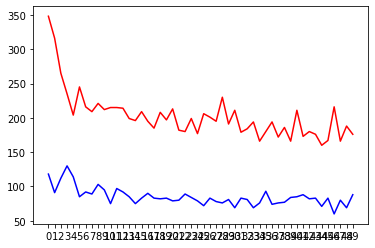

In [19]:
session('agent1.values', 'agent2.values', 0.2, 0.5, 50, 500) #обучение 2 агентов

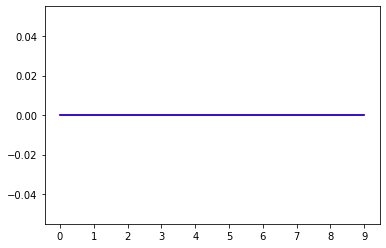

In [20]:
session('agent1.values', 'agent2.values', 0, 0.9, 10, 100) #игра 2 обученных агентов

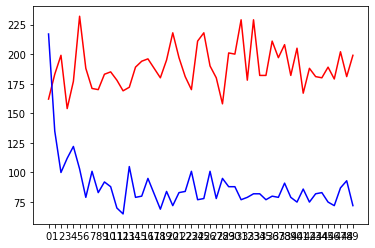

In [21]:
session('agent3.values', 'agent2.values', 0.2, 0.5, 50, 500) #обучение вместе с обученным

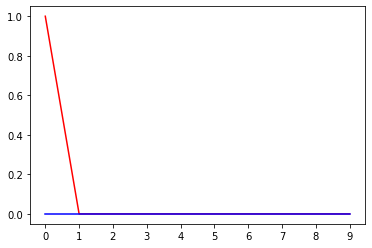

In [22]:
session('agent3.values', 'agent2.values', 0, 0.9, 10, 100) #игра 2 обученных

In [23]:
agent1 = Agent(CROSS, 0, 0.9, 'agent1.values')
agent2 = Agent(ZERO, 0, 0.9, 'agent2.values')
game = Game(agent1, agent2)
game.play_human()


         | | 
        —+—+—
         | |x
        —+—+—
         | | 
        
Введите номер ячейки для хода: 5

         | | 
        —+—+—
         |o|x
        —+—+—
         | | 
        

         | | 
        —+—+—
         |o|x
        —+—+—
        x| | 
        
Введите номер ячейки для хода: 1

        o| | 
        —+—+—
         |o|x
        —+—+—
        x| | 
        

        o| | 
        —+—+—
         |o|x
        —+—+—
        x| |x
        
Введите номер ячейки для хода: 3

        o| |o
        —+—+—
         |o|x
        —+—+—
        x| |x
        
Победа крестиков!

        o| |o
        —+—+—
         |o|x
        —+—+—
        x|x|x
        
